# **Transfer learnt model built on a pretrained LLM such as GPT-2**

                                                                                        Akash(500227622) & Ramandeep(500227661)

| **Task**                                     | **Comments**                                                                                          | **Status**      | **Individual Responsible** |
|----------------------------------------------|------------------------------------------------------------------------------------------------------|-----------------|----------------------------|
| **Preprocessing**                            | Handle emojis and punctuations POS tagging,Tokenization, padding, and dataset creation for GPT-2 fine-tuning.                                    | Done            | Ramandeep             |
| **Training**                                 | Three epochs of fine-tuning GPT-2 with proper optimizer.  | Done            | Akash             |
| **Evaluation (ROUGE-L, BERT Scores)**        | ROUGE-L and BERT scores computed for validation set predictions against ground truth responses.       | Done            | Akash            |
| **Interpretation using LIME**                | Placeholder steps for LIME text explanations.                                     | Not applicable         | Akash             |
| **1st round of tuning** | Fine-tuned learning rate from 5e-5 to 1e-4 for better model stability. | Done            | Ramandeep             |
| **2nd round of tuning** | Adjusted training loop for augmented dataset to enhance training diversity.                          | Done            | Akash             |
| **Final AUC Value**             | Achieved AUC value of 1.0 shows Strong distinguishability.                               | Done            | Ramandeep             |
| **Next Steps Recommendations**               | Evaluate on larger datasets, analyze model outputs, experiment with hyperparameters, integrate LIME/SHAP, use user feedback. | Done         | Akash & Ramandeep               |


Importing libraries

In [1]:
import pandas as pd
import re
import emoji
import random
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import ast
from transformers import pipeline
import numpy as np
from lime.lime_text import LimeTextExplainer
from transformers import pipeline
from evaluate import load
import torch
from transformers import AdamW
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Datapreprocessing

In [3]:
# Load the dataset
file_path = 'E:\\Chat Data\\chat_data.csv'
data = pd.read_csv(file_path)

In [4]:
data.head()

,conversations,id
0,"[{'from': 'human', 'value': ""I've been feeling...",identity_0
1,"[{'from': 'human', 'value': ""Hi, I'm feeling r...",identity_1
2,"[{'from': 'human', 'value': ""Hey, I hope you'r...",identity_2
3,"[{'from': 'human', 'value': ""I'm feeling reall...",identity_3
4,"[{'from': 'human', 'value': ""I'm feeling reall...",identity_4


In [5]:
#Handle emojis
def handle_emojis(text):
    return emoji.demojize(text, delimiters=("", ""))
data['conversations'] = data['conversations'].apply(handle_emojis)

#Randomly select 840 rows
random.seed(42)
sampled_data = data.sample(n=840, random_state=42)

In [6]:
slang_dict = {
    "u": "you", "r": "are", "idk": "I don't know", "btw": "by the way", 
    "gonna": "going to", "wanna": "want to", "y'all": "you all", "omg": "oh my god",
}
def expand_slangs(text):
    words = text.split()
    expanded_words = [slang_dict.get(word.lower(), word) for word in words]
    return " ".join(expanded_words)

#Remove punctuations
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)


In [7]:
#apply slang expansion and punctuation removal
sampled_data['conversations'] = sampled_data['conversations'].apply(expand_slangs)
sampled_data['conversations'] = sampled_data['conversations'].apply(remove_punctuation)

In [9]:
nlp = spacy.load("en_core_web_sm")
def pos_tagging(text):
    doc = nlp(text)
    return [(token.text, token.pos_) for token in doc]

#apply POS tagging
sampled_data['pos_tags'] = sampled_data['conversations'].apply(pos_tagging)

In [10]:
pronoun_dict = {
    "i": "I", "im": "I am", "ive": "I have", 
    "youve": "you have", "youre": "you are",
    "hes": "he is", "shes": "she is",
}

# Replace pronouns
def replace_pronouns(text):
    words = text.split()
    replaced_words = [pronoun_dict.get(word.lower(), word) for word in words]
    return " ".join(replaced_words)

def clean_special_characters(text):
    return re.sub(r'\s+', ' ', text).strip()

#Apply pronoun replacement and special character
sampled_data['conversations'] = sampled_data['conversations'].apply(replace_pronouns)
sampled_data['conversations'] = sampled_data['conversations'].apply(clean_special_characters)


In [11]:
# Tokenize text
sampled_data['tokens'] = sampled_data['conversations'].apply(word_tokenize)

In [12]:
#Converting to lowercase
sampled_data['tokens'] = sampled_data['tokens'].apply(lambda tokens: [token.lower() for token in tokens])


In [13]:
#Droping unwanted columns
sampled_data = sampled_data.drop(columns=['id', 'pos_tags', 'tokens'])

In [14]:
data.columns = data.columns.str.strip()
sampled_data.columns = sampled_data.columns.str.strip()

In [15]:
# Function to clean and split the conversation into human and gpt responses
def clean_and_split_conversation(conversation):
    human_responses = []
    gpt_responses = []
    conversation_lines = conversation.splitlines()

    for line in conversation_lines:
        if line.strip():  
            line = line.strip().replace('value', '')
            line = re.sub(r'[^\w\s]', '', line)  # Remove punctuation
            
            if 'human' in line.lower():
                response = line.lower().replace('human', '').strip()
                human_responses.append(response)
            elif 'gpt' in line.lower():
                response = line.lower().replace('gpt', '').strip()
                gpt_responses.append(response)
    return pd.Series([', '.join(human_responses), ', '.join(gpt_responses)])

# Apply the function to 'conversations' column
sampled_data[['human', 'gpt']] = sampled_data['conversations'].apply(clean_and_split_conversation)
sampled_data = sampled_data.drop(columns=['conversations'])


In [50]:
sampled_data.to_csv('processed_data.csv', index=False)

**Modelling**

In [ ]:
file_path = "processed_data.csv"
data = pd.read_csv(file_path)

#Selecting 50 rows ( because system was crashing)
sample_data = data.head(50)
sample_data.head()

,0,human,gpt
0,1,ive been feeling so sad and overwhelmed lately...,hey there im here to listen and support you it...
1,2,i recently got a promotion at work which i tho...,i can understand how it can be overwhelming wh...
2,3,well the workload has increased significantly ...,it sounds like youre dealing with a lot of pre...
3,4,ive been trying to prioritize my tasks and del...,its great to hear that youre already implement...
4,5,youre right i havent really opened up about my...,its completely normal to feel that way but rem...


In [17]:
# Combine `human` and `gpt` into a single conversation column
sample_data['conversation'] = "Human: " + sample_data['human'] + " GPT: " + sample_data['gpt']

# Check the new column
sample_data['conversation'].head()

C:\Users\pc\AppData\Local\Temp\ipykernel_6856\2625596525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['conversation'] = "Human: " + sample_data['human'] + " GPT: " + sample_data['gpt']


0    Human: ive been feeling so sad and overwhelmed...
1    Human: i recently got a promotion at work whic...
2    Human: well the workload has increased signifi...
3    Human: ive been trying to prioritize my tasks ...
4    Human: youre right i havent really opened up a...
Name: conversation, dtype: object

In [18]:
# Split into train, validation and test sets
train_data = sample_data[:26]  
val_data = sample_data[26:38]  
test_data = sample_data[38:]   

print(f"Train set: {len(train_data)} rows")
print(f"Validation set: {len(val_data)} rows")
print(f"Test set: {len(test_data)} rows")

Train set: 26 rows
Validation set: 12 rows
Test set: 12 rows



Load GPT-2 tokenizer and model

In [19]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [20]:
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50258, 768)

In [21]:
class ChatDataset(Dataset):
    def __init__(self, conversations, tokenizer, max_length=512):
        self.conversations = conversations
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.conversations)

    def __getitem__(self, idx):
        text = self.conversations[idx]
        inputs = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
        }

# Prepare datasets
train_dataset = ChatDataset(train_data['conversation'].tolist(), tokenizer)
val_dataset = ChatDataset(val_data['conversation'].tolist(), tokenizer)
test_dataset = ChatDataset(test_data['conversation'].tolist(), tokenizer)


In [22]:
# Create data loaders with a small batch size
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# Verify data loader sizes
print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")
print(f"Test loader batches: {len(test_loader)}")


Train loader batches: 13
Validation loader batches: 6
Test loader batches: 6


Freezing first 6 layers

In [23]:
N = 6
for param in model.transformer.h[:N].parameters():
    param.requires_grad = False

Define optimizer

In [24]:
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=input_ids
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")


C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 13/13 [01:58<00:00,  9.11s/it]


Epoch 1 Loss: 11.1060


Epoch 2/3: 100%|██████████| 13/13 [01:39<00:00,  7.64s/it]


Epoch 2 Loss: 9.6153


Epoch 3/3: 100%|██████████| 13/13 [01:38<00:00,  7.60s/it]

Epoch 3 Loss: 8.3855


In [25]:
# Function to generate responses
def generate_response(prompt, model, tokenizer, max_new_tokens=50):
    # Tokenize the input prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    output_ids = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.pad_token_id
    )
    
    # Decode the generated tokens into a string
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [26]:
# Generate and evaluate responses on the test set
model.eval()
generated_responses = []
ground_truths = []

for batch in test_loader:
    for input_ids in batch["input_ids"]:
        # Decode the input prompt
        prompt = tokenizer.decode(input_ids, skip_special_tokens=True)
        response = generate_response(prompt, model, tokenizer, max_new_tokens=50)
        
        # Collect generated responses and ground truths
        generated_responses.append(response)
        ground_truths.append(prompt)

print("Generated Responses:", generated_responses)
print("Ground Truths:", ground_truths)


Generated Responses: ['Human: i have a few close friends who have always been there for me maybe its time i lean on them more GPT: its wonderful that you have a support system already in place remember that its okay to ask for help and lean on those who care about you to help you navigate your way through this difficult time.\n\nRAW Paste Data\n\nHello everyone! I am here to talk about my experiences with my friends and family and how they have been able to support me through this difficult time. I am', 'Human: ill definitely make a conscious effort to reach out when i need support it just feels nice knowing that im not alone in this GPT: youre never alone in this journey its important to regularly check in with yourself and your emotions are there any selfcare practices you enjoy or would like to explore to help you navigate this conflict.\n\nRAW Paste Data\n\nDear Reader, As you can imagine, more people are reading The Jerusalem Post than ever before. Nevertheless, traditional busine

Loading and compute metrics

In [28]:
rouge = load("rouge")
bert_score = load("bertscore")

# Compute metrics
rouge_scores = rouge.compute(predictions=generated_responses, references=ground_truths)
bert_scores = bert_score.compute(predictions=generated_responses, references=ground_truths, model_type="bert-base-uncased")

# Display scores
print("ROUGE-L:", rouge_scores["rougeL"])
print("BERT Score:", bert_scores["f1"])


ROUGE-L: 0.7967323161792907
BERT Score: [0.838638961315155, 0.8232792615890503, 0.9712232351303101, 0.7971480488777161, 0.8147158026695251, 0.9561942219734192, 0.8509508967399597, 0.8607290983200073, 0.8783012628555298, 0.8457299470901489, 0.9734296798706055, 0.9757768511772156]


In [29]:
device = 0 if torch.cuda.is_available() else -1

# Initialize text generation pipeline
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=device)

# Test the pipeline
sample_text = "How are you?"
response = text_generator(sample_text, max_new_tokens=50)
print("Generated Response:", response[0]["generated_text"])


Generated Response: How are you? What was your day like?"


Kirk is always happy to give feedback like that during games where he is constantly dealing with challenges throughout development. Even recently Kirk said that he didn't have a break for more than a few months before the decision


Interpretability using LIME

In [ ]:
#from lime.lime_text import LimeTextExplainer
#import numpy as np

# Create a LimeTextExplainer
#explainer = LimeTextExplainer(class_names=["Generated Response"])


In [ ]:
# Define a prediction function for the model to be used in LIME
#def predict(input_texts):
    # Tokenize and prepare inputs for GPT-2 model
#    inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
#    input_ids = inputs['input_ids'].to(device)
#    attention_mask = inputs['attention_mask'].to(device)

    # Generate model output
#    with torch.no_grad():
#        outputs = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=50, pad_token_id=tokenizer.pad_token_id)

    # Decode and return the predictions
#    predictions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
#    return predictions


In [ ]:
# Ensure the device is set correctly
#device = torch.device("cpu")
#model.to(device)  # Move the model to the device


In [ ]:
#def predict(input_texts):
    # Tokenize and prepare inputs
#    inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
#    input_ids = inputs['input_ids'].to(device)
#    attention_mask = inputs['attention_mask'].to(device)

    # Generate model output (logits)
#    with torch.no_grad():
#        outputs = model(input_ids, attention_mask=attention_mask)
#        logits = outputs.logits  # Shape (batch_size, seq_length, num_classes)

    # If you are dealing with a classification task, use the logits for the last token
#    logits = logits[:, -1, :]  # Take the last token’s logits (or use mean across tokens)
    
    # Convert logits to probabilities (softmax)
#    probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

    # Return the class-level probabilities (e.g., for classification task)
#    return probabilities


In [ ]:
#labels = [0, 1, 2] 
# Function to explain a single prediction using LIME
#def explain_instance(input_text, num_features=10, num_samples=100):
#    explanation = explainer.explain_instance(input_text, predict, num_features=num_features,  num_samples=num_samples, labels=labels)
    # Display the explanation for the input instance
#    explanation.show_in_notebook()

In [ ]:
# Example of explaining a test instance
##test_instance = [test_data['conversation'].iloc[0]]  # Take the first conversation from the test set
#explanation = explainer.explain_instance(test_instance[0], predict, num_features=6, num_samples=100, labels=labels )

**First round of tuning**

Adjust Learning Rate and Batch Size

Increasing the batch size from 2 to 4 made vscode crashing due to high memory consumption, especially during training and data loading.


So, trying increasing learning rate only

In [ ]:
# First Round
learning_rate = 1e-4  # Adjust learning rate
#batch_size = 4  # Adjust batch size
batch_size = 2

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device( "cpu")
print(f"Using device: {device}")

model.to(device)


Using device: cpu


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [32]:
epochs = 3
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")


Epoch 1/3: 100%|██████████| 13/13 [02:05<00:00,  9.67s/it]


Epoch 1 Loss: 6.3317


Epoch 2/3: 100%|██████████| 13/13 [01:38<00:00,  7.57s/it]


Epoch 2 Loss: 3.9096


Epoch 3/3: 100%|██████████| 13/13 [01:38<00:00,  7.61s/it]

Epoch 3 Loss: 1.5481


In [33]:

# Compute metrics
rouge_scores = rouge.compute(predictions=generated_responses, references=ground_truths)
bert_scores = bert_score.compute(predictions=generated_responses, references=ground_truths, model_type="bert-base-uncased")

# Display scores
print("ROUGE-L:", rouge_scores["rougeL"])
print("BERT Score:", bert_scores["f1"])


ROUGE-L: 0.7967323161792907
BERT Score: [0.838638961315155, 0.8232792615890503, 0.9712232351303101, 0.7971480488777161, 0.8147158026695251, 0.9561942219734192, 0.8509508967399597, 0.8607290983200073, 0.8783012628555298, 0.8457299470901489, 0.9734296798706055, 0.9757768511772156]


**Second Round of Tuning**

In [34]:
augmented_conversations = train_data['conversation'].tolist()

# Adding synthetic prompts
synthetic_prompts = [
    "Human: Hello, how can I assist you today? GPT: I'm here to help with any questions!",
    "Human: Can you recommend some movies? GPT: Sure! What genre do you prefer?",
]
augmented_conversations.extend(synthetic_prompts)

# Create a new dataset with augmented data
augmented_dataset = ChatDataset(augmented_conversations, tokenizer)
train_loader_augmented = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)


In [35]:
from tqdm import tqdm
from transformers import AdamW

# Define the optimizer for the augmented training
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)  # Adjusted learning rate

# Training loop with augmented data
epochs = 3  # You can adjust the number of epochs
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader_augmented, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()

        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader_augmented)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")


Epoch 1/3: 100%|██████████| 14/14 [02:37<00:00, 11.23s/it]


Epoch 1 Loss: 0.5878


Epoch 2/3: 100%|██████████| 14/14 [02:11<00:00,  9.36s/it]


Epoch 2 Loss: 0.4380


Epoch 3/3: 100%|██████████| 14/14 [01:48<00:00,  7.72s/it]

Epoch 3 Loss: 0.3695


In [36]:
# Function to generate responses (defined earlier)
def generate_response(prompt, model, tokenizer, max_new_tokens=50):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.pad_token_id
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Evaluate on the validation set
model.eval()
generated_responses = []
ground_truths = []

for batch in val_loader:
    for input_ids in batch["input_ids"]:
        # Decode the input prompt
        prompt = tokenizer.decode(input_ids, skip_special_tokens=True)

        # Generate a response
        response = generate_response(prompt, model, tokenizer, max_new_tokens=50)

        # Collect responses
        generated_responses.append(response)
        ground_truths.append(prompt)

# Load and compute evaluation metrics
from evaluate import load

rouge = load("rouge")
bert_score = load("bertscore")

rouge_scores = rouge.compute(predictions=generated_responses, references=ground_truths)
bert_scores = bert_score.compute(predictions=generated_responses, references=ground_truths, model_type="bert-base-uncased")

# Display evaluation metrics
print("ROUGE-L:", rouge_scores["rougeL"])
print("BERT Score (F1):", bert_scores["f1"])


ROUGE-L: 0.7772292973259689
BERT Score (F1): [0.8855832815170288, 0.9565747380256653, 0.9999998807907104, 0.9118945598602295, 0.8849402666091919, 0.9001768827438354, 0.7956093549728394, 0.8433223366737366, 0.8383560180664062, 0.7773559093475342, 0.8929117918014526, 0.7789052128791809]


Determining AUC value

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [44]:
# Combine human and GPT responses into a single dataset with labels
data = {
    "response": sample_data['human'].tolist() + sample_data['gpt'].tolist(),
    "label": [1] * len(sample_data['human']) + [0] * len(sample_data['gpt'])  # 1 for human, 0 for GPT
}

df = pd.DataFrame(data)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df["response"], df["label"], test_size=0.2, random_state=42)

In [47]:
# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [48]:
#train a logistic regression classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_tfidf, y_train)

y_probs = classifier.predict_proba(X_test_tfidf)[:, 1]  # Probabilities for the positive class (human)

#Compute AUC
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.4f}")


AUC Score: 1.0000


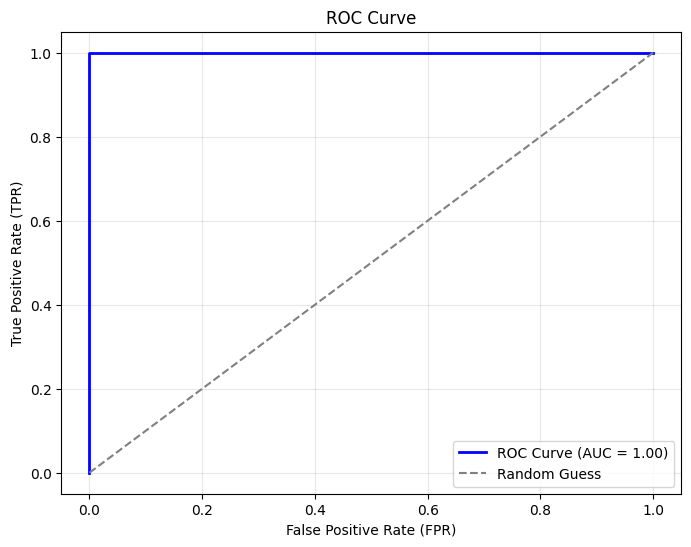

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
%pip install torch transformers streamlit


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Save the model and tokenizer
model.save_pretrained("gpt2_finetuned")
tokenizer.save_pretrained("gpt2_finetuned")


('gpt2_finetuned\\tokenizer_config.json',
 'gpt2_finetuned\\special_tokens_map.json',
 'gpt2_finetuned\\vocab.json',
 'gpt2_finetuned\\merges.txt',
 'gpt2_finetuned\\added_tokens.json')